# IMDB Rating Prediction

In [1]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Data Preprocessing

In [2]:
#reading dataset
df=pd.read_csv("ratings.csv",encoding='latin-1')


In [3]:
#removing nulls and spaces
df.columns = df.columns.str.replace(' ', '')
df['Genres']=df['Genres'].apply(lambda x: x.replace(' ',''))
df = df.dropna(axis=0, subset=['Runtime(mins)'])


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 594
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Const          591 non-null    object 
 1   YourRating     591 non-null    int64  
 2   DateRated      591 non-null    object 
 3   Title          591 non-null    object 
 4   URL            591 non-null    object 
 5   TitleType      591 non-null    object 
 6   IMDbRating     591 non-null    float64
 7   Runtime(mins)  591 non-null    float64
 8   Year           591 non-null    int64  
 9   Genres         591 non-null    object 
 10  NumVotes       591 non-null    int64  
 11  ReleaseDate    590 non-null    object 
 12  Directors      526 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 64.6+ KB


In [5]:
df

,Const,YourRating,DateRated,Title,URL,TitleType,IMDbRating,Runtime(mins),Year,Genres,NumVotes,ReleaseDate,Directors
0,tt1001526,7,22/02/2015,Megamind,https://www.imdb.com/title/tt1001526/,movie,7.2,95.0,2010,"Animation,Action,Comedy,Family,Sci-Fi",220996,28/10/2010,Tom McGrath
1,tt1010048,8,22/02/2015,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120.0,2008,"Drama,Romance",782252,30/08/2008,"Loveleen Tandan, Danny Boyle"
2,tt1013743,6,25/02/2015,Knight and Day,https://www.imdb.com/title/tt1013743/,movie,6.3,109.0,2010,"Action,Adventure,Comedy",176267,16/06/2010,James Mangold
3,tt1013752,7,25/02/2015,Fast & Furious,https://www.imdb.com/title/tt1013752/,movie,6.6,107.0,2009,"Action,Thriller",256049,12/03/2009,Justin Lin
4,tt0101414,8,23/07/2015,Beauty and the Beast,https://www.imdb.com/title/tt0101414/,movie,8.0,84.0,1991,"Animation,Family,Fantasy,Musical,Romance",408408,29/09/1991,"Kirk Wise, Gary Trousdale"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,tt0097757,7,22/02/2015,The Little Mermaid,https://www.imdb.com/title/tt0097757/,movie,7.6,83.0,1989,"Animation,Family,Fantasy,Musical,Romance",229726,13/11/1989,"Ron Clements, John Musker"
591,tt0983193,8,22/02/2015,The Adventures of Tintin,https://www.imdb.com/title/tt0983193/,movie,7.3,107.0,2011,"Animation,Action,Adventure,Family,Mystery",211976,23/10/2011,Steven Spielberg
592,tt0986264,8,07/03/2015,Taare Zameen Par,https://www.imdb.com/title/tt0986264/,movie,8.4,165.0,2007,"Drama,Family",159002,21/12/2007,"Aamir Khan, Amole Gupte"
593,tt0993846,8,22/02/2015,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,movie,8.2,180.0,2013,"Biography,Crime,Drama",1126484,09/12/2013,Martin Scorsese


In [6]:
df.Genres.nunique()

261

### Genre Analysis

In [7]:
# splitting genres on |
g=df[['Genres','YourRating']].apply(lambda x:[(n,x[1]) for n in x[0].split(',')],axis=1)
all_genres=[]
# appending all genres into a list
g.apply(lambda x:[all_genres.append(n) for n in x])
#making a new dataframe
genres_df=pd.DataFrame(all_genres,columns=['genres','rating'])

In [8]:
genres_df.genres.unique()

array(['Animation', 'Action', 'Comedy', 'Family', 'Sci-Fi', 'Drama',
       'Romance', 'Adventure', 'Thriller', 'Fantasy', 'Musical', 'Crime',
       'Mystery', 'Biography', 'History', 'Horror', 'Sport', 'Music',
       'Western', 'War', 'Short', 'Documentary'], dtype=object)

In [9]:
#making bins
genres_df['genre_bins']=pd.cut(genres_df.rating,bins=[1,2,3,4,5,6,7,8,9,10],right=False)
genres_df.genre_bins.head()

0    [7, 8)
1    [7, 8)
2    [7, 8)
3    [7, 8)
4    [7, 8)
Name: genre_bins, dtype: category
Categories (9, interval[int64]): [[1, 2) < [2, 3) < [3, 4) < [4, 5) ... [6, 7) < [7, 8) < [8, 9) < [9, 10)]

In [10]:
def func(df):
    return df.groupby('genres').size().to_frame('count').sort_values(by='count',ascending=False).iloc[:3]

# groupby each genre and using the count function to find top 3 occurences of each rating
genre_graph=genres_df.groupby(['genre_bins']).apply(func)
genre_graph

count
genre_bins genres          
[1, 2)     Action         1
           Adventure      1
           Drama          1
[4, 5)     Horror         1
           Mystery        1
           Thriller       1
[5, 6)     Thriller       9
           Horror         7
           Action         4
[6, 7)     Comedy        47
           Adventure     40
           Family        34
[7, 8)     Adventure    117
           Action       101
           Comedy        99
[8, 9)     Drama        119
           Adventure     78
           Action        73
[9, 10)    Drama         32
           Adventure     25
           Fantasy       24

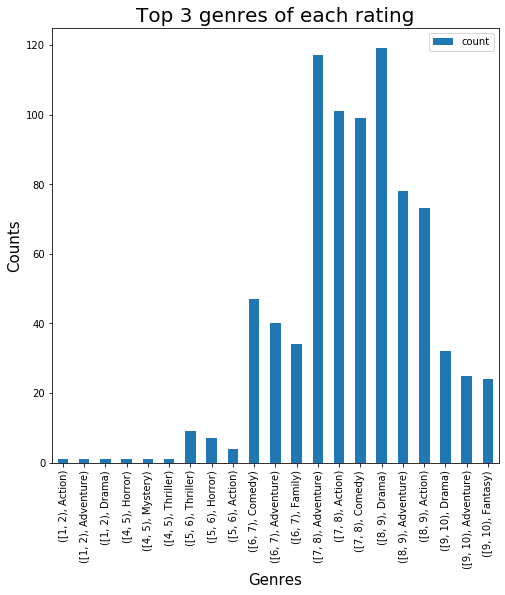

In [11]:
#top 3 genre of each rating
genre_graph.plot(kind='bar',figsize=(8,8),legend=True);
plt.title('Top 3 genres of each rating',fontsize="20")
plt.xlabel("Genres",fontsize="15")
plt.ylabel("Counts",fontsize="15")
plt.show()

### Data Wrangling

In [12]:
#One hot encoding columns
df1 = pd.concat([df.drop('Genres', 1), df['Genres'].str.get_dummies(sep=",")], 1)
df1=pd.concat([df1.drop('TitleType', 1), df1['TitleType'].str.get_dummies(sep=",")], 1)


In [13]:
df1

,Const,YourRating,DateRated,Title,URL,IMDbRating,Runtime(mins),Year,NumVotes,ReleaseDate,...,Thriller,War,Western,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvSpecial,video
0,tt1001526,7,22/02/2015,Megamind,https://www.imdb.com/title/tt1001526/,7.2,95.0,2010,220996,28/10/2010,...,0,0,0,1,0,0,0,0,0,0
1,tt1010048,8,22/02/2015,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,8.0,120.0,2008,782252,30/08/2008,...,0,0,0,1,0,0,0,0,0,0
2,tt1013743,6,25/02/2015,Knight and Day,https://www.imdb.com/title/tt1013743/,6.3,109.0,2010,176267,16/06/2010,...,0,0,0,1,0,0,0,0,0,0
3,tt1013752,7,25/02/2015,Fast & Furious,https://www.imdb.com/title/tt1013752/,6.6,107.0,2009,256049,12/03/2009,...,1,0,0,1,0,0,0,0,0,0
4,tt0101414,8,23/07/2015,Beauty and the Beast,https://www.imdb.com/title/tt0101414/,8.0,84.0,1991,408408,29/09/1991,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,tt0097757,7,22/02/2015,The Little Mermaid,https://www.imdb.com/title/tt0097757/,7.6,83.0,1989,229726,13/11/1989,...,0,0,0,1,0,0,0,0,0,0
591,tt0983193,8,22/02/2015,The Adventures of Tintin,https://www.imdb.com/title/tt0983193/,7.3,107.0,2011,211976,23/10/2011,...,0,0,0,1,0,0,0,0,0,0
592,tt0986264,8,07/03/2015,Taare Zameen Par,https://www.imdb.com/title/tt0986264/,8.4,165.0,2007,159002,21/12/2007,...,0,0,0,1,0,0,0,0,0,0
593,tt0993846,8,22/02/2015,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,8.2,180.0,2013,1126484,09/12/2013,...,0,0,0,1,0,0,0,0,0,0


In [14]:
#dropping redundant columns
df1=df1.drop(['Title','Const','DateRated','URL','Directors','ReleaseDate'], axis = 1) 



In [15]:
df1

,YourRating,IMDbRating,Runtime(mins),Year,NumVotes,Action,Adventure,Animation,Biography,Comedy,...,Thriller,War,Western,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvSpecial,video
0,7,7.2,95.0,2010,220996,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,8,8.0,120.0,2008,782252,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6,6.3,109.0,2010,176267,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,7,6.6,107.0,2009,256049,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,8,8.0,84.0,1991,408408,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,7,7.6,83.0,1989,229726,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
591,8,7.3,107.0,2011,211976,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
592,8,8.4,165.0,2007,159002,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
593,8,8.2,180.0,2013,1126484,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
#looking for correlation
df1.corr()

,YourRating,IMDbRating,Runtime(mins),Year,NumVotes,Action,Adventure,Animation,Biography,Comedy,...,Thriller,War,Western,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvSpecial,video
YourRating,1.000000,0.695968,0.053296,0.012577,0.434174,-0.075914,-0.033496,-0.034121,0.105970,-0.181387,...,0.066582,0.120030,-0.006183,-0.156215,-0.266257,0.068828,-0.022580,0.285575,0.006944,-0.080606
IMDbRating,0.695968,1.000000,0.109431,-0.125036,0.488726,-0.130652,-0.134545,-0.120037,0.134407,-0.169603,...,0.024880,0.125373,-0.014248,-0.174884,-0.142688,0.102624,0.006090,0.338641,0.009195,-0.154939
Runtime(mins),0.053296,0.109431,1.000000,-0.009206,0.303239,0.010250,-0.121776,-0.437714,0.094388,-0.154481,...,-0.018285,0.186648,0.075797,0.514727,-0.028740,0.354997,-0.027179,-0.548756,-0.044729,-0.208405
Year,0.012577,-0.125036,-0.009206,1.000000,-0.109240,0.164987,0.133606,-0.109068,0.047774,0.051924,...,0.098795,-0.025580,-0.015378,-0.076670,0.043783,0.031721,0.024074,0.038882,0.034902,0.041643
NumVotes,0.434174,0.488726,0.303239,-0.109240,1.000000,-0.002937,0.037953,-0.303066,0.055153,-0.237963,...,0.052972,0.077856,-0.000096,0.256675,-0.014061,-0.007864,-0.046441,-0.111467,-0.055284,-0.235965
Action,-0.075914,-0.130652,0.010250,0.164987,-0.002937,1.000000,0.313672,-0.029704,-0.132645,-0.186722,...,0.209226,-0.055376,0.042903,-0.113107,0.051762,0.040934,-0.046347,0.015569,-0.046347,0.159665
Adventure,-0.033496,-0.134545,-0.121776,0.133606,0.037953,0.313672,1.000000,0.409375,-0.190134,0.085411,...,-0.213709,-0.073828,0.054136,-0.007428,0.045507,-0.016762,-0.052718,-0.027446,-0.052718,0.067899
Animation,-0.034121,-0.120037,-0.437714,-0.109068,-0.303066,-0.029704,0.409375,1.000000,-0.133550,0.259845,...,-0.209989,-0.074403,-0.017973,-0.293377,-0.026161,-0.045389,-0.037029,0.067003,-0.037029,0.412521
Biography,0.105970,0.134407,0.094388,0.047774,0.055153,-0.132645,-0.190134,-0.133550,1.000000,-0.121515,...,-0.062587,0.188378,-0.026135,0.055153,-0.008652,-0.015012,0.132509,-0.043668,-0.012247,-0.055092
Comedy,-0.181387,-0.169603,-0.154481,0.051924,-0.237963,-0.186722,0.085411,0.259845,-0.121515,1.000000,...,-0.306217,-0.092849,0.022690,0.111905,-0.030678,-0.053226,-0.043422,-0.020643,0.078200,-0.137743


In [17]:
df1.shape

(591, 34)

In [18]:
df1.describe()

,YourRating,IMDbRating,Runtime(mins),Year,NumVotes,Action,Adventure,Animation,Biography,Comedy,...,Thriller,War,Western,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvSpecial,video
count,591.000000,591.000000,591.000000,591.000000,5.910000e+02,591.000000,591.000000,591.000000,591.000000,591.000000,...,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,7.382403,7.351946,110.133672,2007.553299,3.463637e+05,0.387479,0.450085,0.287648,0.042301,0.357022,...,0.248731,0.023689,0.015228,0.818951,0.001692,0.005076,0.003384,0.103215,0.003384,0.064298
std,0.987701,0.939072,43.202527,10.772538,3.613969e+05,0.487587,0.497924,0.453050,0.201446,0.479527,...,0.432644,0.152206,0.122564,0.385385,0.041135,0.071126,0.058124,0.304497,0.058124,0.245490
min,1.000000,4.100000,11.000000,1937.000000,3.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,6.800000,89.000000,2004.000000,7.899950e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,7.400000,108.000000,2010.000000,2.374940e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,8.000000,131.500000,2014.000000,4.806265e+05,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,9.500000,594.000000,2019.000000,2.256593e+06,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 594
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YourRating     591 non-null    int64  
 1   IMDbRating     591 non-null    float64
 2   Runtime(mins)  591 non-null    float64
 3   Year           591 non-null    int64  
 4   NumVotes       591 non-null    int64  
 5   Action         591 non-null    int64  
 6   Adventure      591 non-null    int64  
 7   Animation      591 non-null    int64  
 8   Biography      591 non-null    int64  
 9   Comedy         591 non-null    int64  
 10  Crime          591 non-null    int64  
 11  Documentary    591 non-null    int64  
 12  Drama          591 non-null    int64  
 13  Family         591 non-null    int64  
 14  Fantasy        591 non-null    int64  
 15  History        591 non-null    int64  
 16  Horror         591 non-null    int64  
 17  Music          591 non-null    int64  
 18  Musical   

## Model Training

In [20]:
#Defining training and test set
X = df1.loc[:,df1.columns != 'YourRating']
y = df1['YourRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [21]:
#Model Training
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Prediction on Test set and analysis

In [22]:
#Prediction
y_pred = regressor.predict(X_test)

In [23]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2

,Actual,Predicted
226,9,8.364332
14,6,7.667195
85,8,7.322576
422,7,7.023208
132,8,7.294079
214,8,7.777597
187,8,7.420369
343,7,7.489556
122,6,6.882913
398,7,7.824339


In [24]:
#Actual vs Predicted
y_predicted = regressor.predict(X)
df3=df
df3['Actual']= y
df3['Predicted']=y_predicted
df3=df3[['Title','Actual','Predicted']]
df3.head(25)

,Title,Actual,Predicted
0,Megamind,7,7.157385
1,Slumdog Millionaire,8,7.984235
2,Knight and Day,6,6.552270
3,Fast & Furious,7,6.896112
4,Beauty and the Beast,8,8.031296
5,(500) Days of Summer,8,7.484435
6,Om Shanti Om,8,7.085712
7,Hachi: A Dog's Tale,6,7.640715
8,The Silence of the Lambs,9,8.389442
9,Sing si lip yan,6,6.301157


In [25]:
df3.sort_values(by=['Actual'], ascending=False).head(10)

,Title,Actual,Predicted
283,Shingeki no kyojin,10,8.393694
494,The Prestige,10,8.592310
27,The Lion King,10,8.796966
18,Friends,10,8.593669
435,The Departed,10,8.478418
483,The Dark Knight,10,9.544222
572,Breaking Bad,10,9.718882
555,Interstellar,10,8.685566
110,Inception,10,9.079873
279,The Pianist,9,8.447793


In [26]:
df3.sort_values(by=['Predicted'], ascending=False).head(10)

,Title,Actual,Predicted
581,Game of Thrones,9,9.879527
572,Breaking Bad,10,9.718882
483,The Dark Knight,10,9.544222
33,The Shawshank Redemption,9,9.463097
134,Sherlock,9,9.404776
252,True Detective,9,9.203236
563,Death Note: Desu nôto,9,9.174400
110,Inception,10,9.079873
109,Fight Club,9,8.951692
31,Pulp Fiction,9,8.922484


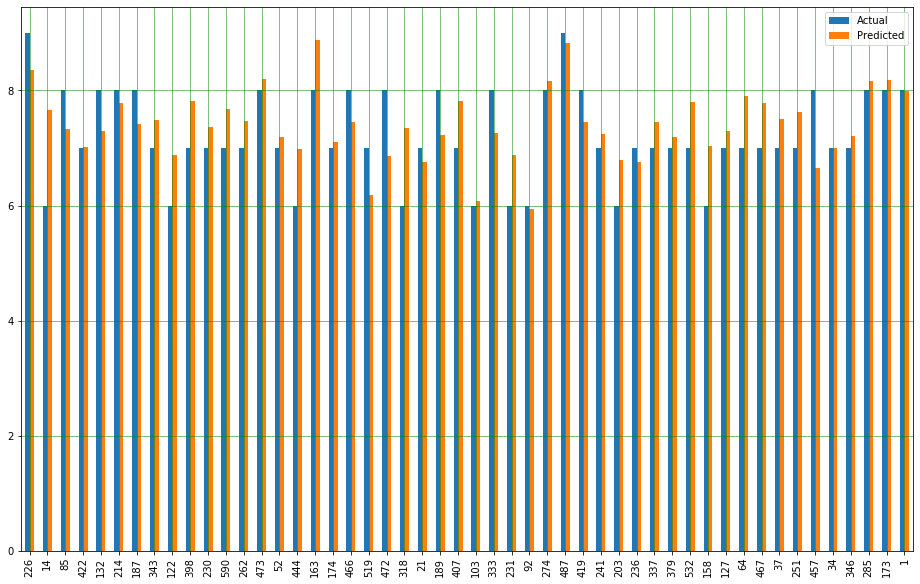

In [27]:
df3=df2.head(50)
df3.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [28]:
# Measurements
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5699856299442726
Mean Squared Error: 0.48946288894598555
Root Mean Squared Error: 0.6996162440552575


### Predictions on Unseen data

In [29]:
#Future Prediction Function
def Prediction(Title,IMDbRating, Runtime, Year, NumVotes,Action=0, Adventure=0, Animation=0, Biography=0, Comedy=0, Crime=0,Documentary=0, Drama=0, Family=0, Fantasy=0, History=0, Horror=0,Music=0, Musical=0, Mystery=0, Romance=0, Sci_Fi=0, Short=0, Sport=0,Thriller=0, War=0, Western=0, movie=0, tvEpisode=0, tvMiniSeries=0,tvMovie=0, tvSeries=0, tvSpecial=0, video=0):
    parameters= (list(locals().values()))
    parameters=parameters[1:]
    df_test=pd.DataFrame(columns=['IMDbRating', 'Runtime(mins)', 'Year', 'NumVotes','Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime','Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror','Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport','Thriller', 'War', 'Western', 'movie', 'tvEpisode', 'tvMiniSeries','tvMovie', 'tvSeries', 'tvSpecial', 'video'])
    #print(len(locals().keys()))
    #print (len(df_test.columns))
    #print (df_test.columns)

    column=list(df_test.columns)
    #print (len(parameters),len(column))
    df_test.loc[-1] =parameters
#     for i,x in enumerate(column):
#         #print (i,x)
#         df_test[i]=str(parameters[i])
#         print (df_test[x])/

#     print (df_test)
    printmd ("Predicted rating for " +str(Title)+  " is: **"+ str(round(regressor.predict(df_test)[0],2))+"**")

In [30]:
Prediction('Dark',8.8,60,2017,204485,Crime=1,Drama=1,Mystery=1,tvSeries=1)

Predicted rating for Dark is: **8.91**

In [31]:
Prediction('Money Heist',8.4,70,2017,255477,Crime=1,Action=1,Mystery=1,tvSeries=1)

Predicted rating for Money Heist is: **8.71**